Notebook for calculating the Xray power and rate for certain vibrational stabilities.

We need to do an analysis of the modes in the chamber, so that we can see what kind of accuracy we should expect from an IDS channel inside the chamber itself. 

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from xraydb import xray_edge

In [177]:
#rough equation for xray power
def xrConvEff(z, kv=10):
    return 10**-8 * z * kv

def power(current_uA, kv):
    return current_uA * 10**-3 * kv



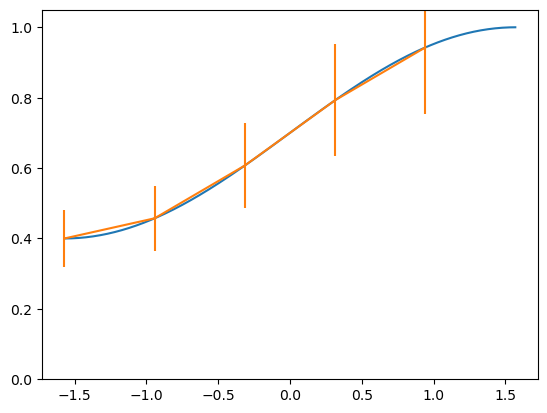

In [178]:
xVec = np.arange(-np.pi/2,np.pi/2, 0.01)
def sinFunc(x):
    return 0.3*np.sin(x)+0.7

def invSinFunc(sin):
    return np.arcsin((sin - 0.7)/0.3)


yVec = sinFunc(xVec)

samples = np.arange(-np.pi/2,np.pi/2, np.pi/5)
ySamples = sinFunc(samples)

#detections per point
rate = 25
def errorbarCalc(n, value):
    error = value / np.sqrt(n)
    return error

plt.plot(xVec, yVec)
plt.errorbar(samples, ySamples, yerr=errorbarCalc(rate, ySamples))
plt.ylim([0, 1.05])
plt.show()

/var/folders/v8/f7ff7bzn66z3q5_fw16grwb80000gn/T/ipykernel_92500/1207682821.py:6: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((sin - 0.7)/0.3)


Text(0.5, 1.0, 'Error in position from Poisson counting error of a normalised sine \n Samples = 25')

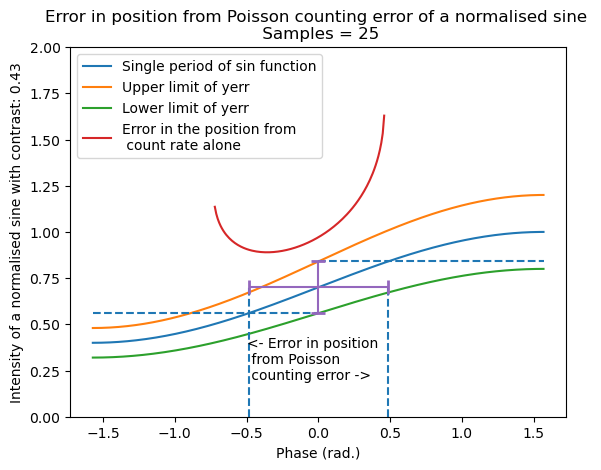

In [179]:
#now we need to calculate the position error pErr from the limits of the yerr and the invSin function

totalyErr = errorbarCalc(rate, yVec)
yUpper = yVec + totalyErr
yLower = yVec - totalyErr

xLeft = invSinFunc(yUpper)
xRight = invSinFunc(yLower)
pErr = np.abs(xRight - xLeft)

plt.plot(xVec, yVec, label='Single period of sin function')
plt.plot(xVec, yUpper, label='Upper limit of yerr')
plt.plot(xVec, yLower, label='Lower limit of yerr')
plt.plot(xVec, pErr, label='Error in the position from \n count rate alone')
#plot dashed horizontal line at height of yerr lower limit and upper limit
plt.hlines(sinFunc(0)+errorbarCalc(rate,sinFunc(0)), 0, np.pi/2, linestyles='dashed')
plt.hlines(sinFunc(0)-errorbarCalc(rate,sinFunc(0)), -np.pi/2, 0, linestyles='dashed')
#now the vertical lines
plt.vlines(invSinFunc(sinFunc(0)+errorbarCalc(rate,sinFunc(0))), 0, sinFunc(0), linestyles='dashed')
plt.vlines(invSinFunc(sinFunc(0)-errorbarCalc(rate,sinFunc(0))), 0, sinFunc(0), linestyles='dashed')
#add a note about the error bars
plt.text(-0.5, 0.2, '<- Error in position \n from Poisson \n counting error ->')
#end capped error bar
plt.errorbar(0,sinFunc(0),
             yerr=errorbarCalc(rate,sinFunc(0)),
             xerr=[[np.abs(invSinFunc(sinFunc(0)-errorbarCalc(rate,sinFunc(0))))], 
                   [np.abs(invSinFunc(sinFunc(0)+errorbarCalc(rate,sinFunc(0))))]], capsize=5, capthick=2)
#legend in top left
plt.legend(loc='upper left')
plt.ylabel('Intensity of a normalised sine with contrast: 0.43')
plt.xlabel('Phase (rad.)')
plt.ylim([0, 2])
plt.title(f'Error in position from Poisson counting error of a normalised sine \n Samples = {rate:.3g}')

/var/folders/v8/f7ff7bzn66z3q5_fw16grwb80000gn/T/ipykernel_92500/1207682821.py:6: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin((sin - 0.7)/0.3)


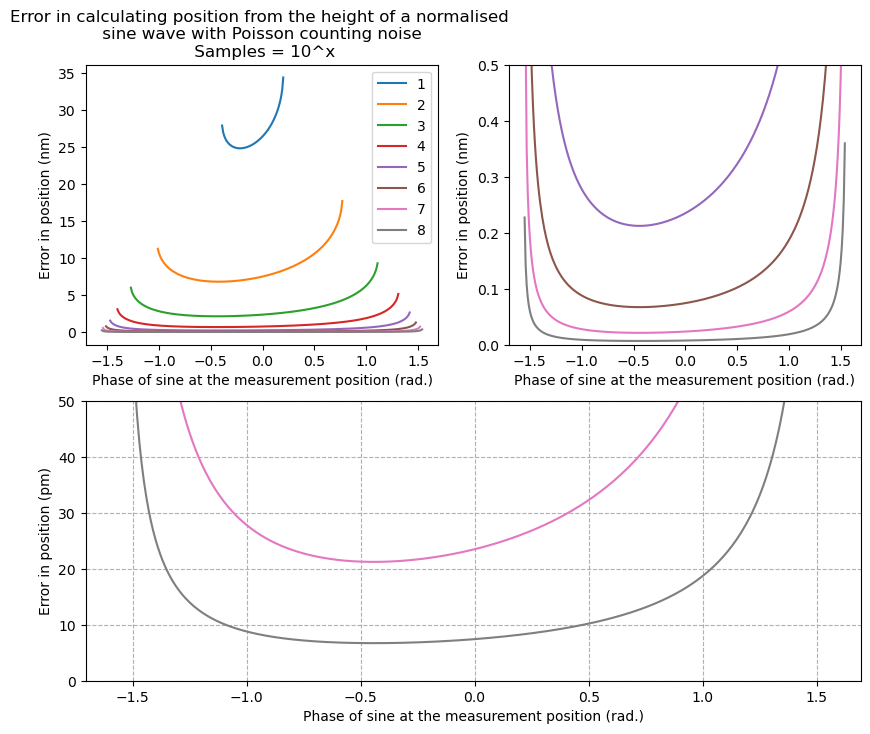

In [186]:
def perror(xvec, n, contrast):
    yvec = sinFunc(xvec)
    yerror = errorbarCalc(n, yvec)
    yup = yvec + yerror
    ydown = yvec - yerror
    xL = invSinFunc(yup)
    xR = invSinFunc(ydown)
    perr = np.abs(xR - xL)
    return perr

oneToNine = np.arange(1,9)
nvec = 10**oneToNine

#factor to convert radians to nm for a period of 100nm
radToNM = 100/(2*np.pi)

# Create figure with GridSpec for layout control
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

#plot the error in position for each sample size
ax1 = plt.subplot(gs[0, 0])
for i in oneToNine:
    plt.plot(xVec, perror(xVec, 10**i, 0.3)*radToNM, label=i)
plt.legend()
plt.xlabel('Phase of sine at the measurement position (rad.)')
plt.ylabel('Error in position (nm)')
plt.title('Error in calculating position from the height of a normalised \n sine wave with Poisson counting noise \n Samples = 10^x')

ax1 = plt.subplot(gs[0, 1])
for i in oneToNine:
    plt.plot(xVec, perror(xVec, 10**i, 0.3)*radToNM, label=i)
    plt.xlabel('Phase of sine at the measurement position (rad.)')
    plt.ylabel('Error in position (nm)')
    plt.ylim([0, .5])

ax1 = plt.subplot(gs[1,:])
for i in oneToNine:
    plt.plot(xVec, perror(xVec, 10**i, 0.3)*radToNM*10**3, label=i)
    plt.xlabel('Phase of sine at the measurement position (rad.)')
    plt.ylabel('Error in position (pm)')
    plt.ylim([0, 50])
    plt.grid(linestyle='--')

plt.show()

If we are aiming for a heat load of around 100-400uW from xrays alone, we can calculate the time to get this many xrays. We will additionally have heat load from the muons, radiation, detectors, IDS.

Assuming 3x xray energy for an electron to create a k-peak x-ray.

It looks as though we need 10^7 x rays for 30pm precision and 10^8 for 10pm. 



In [181]:
#get x ray energy from database for Si and Ti
Si_xrayEnergy = xray_edge('Si', edge='K').energy
Ti_xrayEnergy = xray_edge('Ti', edge='K').energy
print(Si_xrayEnergy, Ti_xrayEnergy)

#calculate the power of the x rays
def energyPerE(energy):
    return energy * 1.60218 * 10**-19 * 3

def timeAtWattage(heatLoadInuW, energyperxray, numberofxray):
    return energyperxray / heatLoadInuW *10**6 * numberofxray

power = 100
xrayRate = 10**7
siTime100 = timeAtWattage(power, energyPerE(Si_xrayEnergy), xrayRate)
tiTime100 = timeAtWattage(power, energyPerE(Ti_xrayEnergy), xrayRate)
print(f'total time for {power}uW at a rate of {xrayRate}: Si ', siTime100, '. Ti ', tiTime100)
print('Fraction of 10us window: Si ', np.round(siTime100/10**-6), '. Ti ', np.round(tiTime100/10**-6))


1839.0 4966.0
total time for 100uW at a rate of 10000000: Si  8.83922706e-05 . Ti  0.00023869277639999997
Fraction of 10us window: Si  88.0 . Ti  239.0
